In [1]:
import json
import sys

sys.path.append("/workspace/circuit-finder")
from circuit_finder.patching.eap_graph import EAPGraph
from circuit_finder.constants import ProjectDir
from circuit_finder.plotting import show_attrib_graph

results_dir = ProjectDir / "results" / "leap_experiment" / "batch_0"
print(results_dir)
assert results_dir.exists()

/home/daniel/ml_workspace/circuit-finder/results/leap_experiment/batch_0


# Print Hparams

In [2]:
config = json.load(open(results_dir / "config.json"))
for key, value in config.items():
    print(f"{key}: {value}")

dataset_path: datasets/ioi/ioi_vanilla_template_prompts.json
save_dir: results/leap_experiment
seed: 1
batch_size: 4
total_dataset_size: 1024
ablate_nodes: bm
ablate_errors: False
ablate_tokens: clean
first_ablate_layer: 2
verbose: False


# Show Dataset

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

dataset = results_dir / "dataset.json"
with open(dataset, 'r') as f:
    dataset = json.load(f)

df = pd.DataFrame(dataset)
df.head()

,clean,answer,wrong_answer,corrupt
0,"<|endoftext|>When Ruby and Charlie went to the house, Charlie gave a snack to",Ruby,Charlie,"<|endoftext|>When Eva and Anna went to the house, Connor gave a snack to"
1,"<|endoftext|>When Thomas and Arthur went to the hospital, Arthur gave a basketball to",Thomas,Arthur,"<|endoftext|>When Dean and Crew went to the hospital, Frank gave a basketball to"
2,"<|endoftext|>When Robert and Crystal went to the house, Crystal gave a bone to",Robert,Crystal,"<|endoftext|>When Frank and Russell went to the house, Simon gave a bone to"
3,"<|endoftext|>When Blake and Jane went to the restaurant, Jane gave a kiss to",Blake,Jane,"<|endoftext|>When Emily and Sean went to the restaurant, Jennifer gave a kiss to"


# Plot Graph

Threshold: 0.001, n_edges: 16731
Threshold: 0.006, n_edges: 539
Threshold: 0.01, n_edges: 214


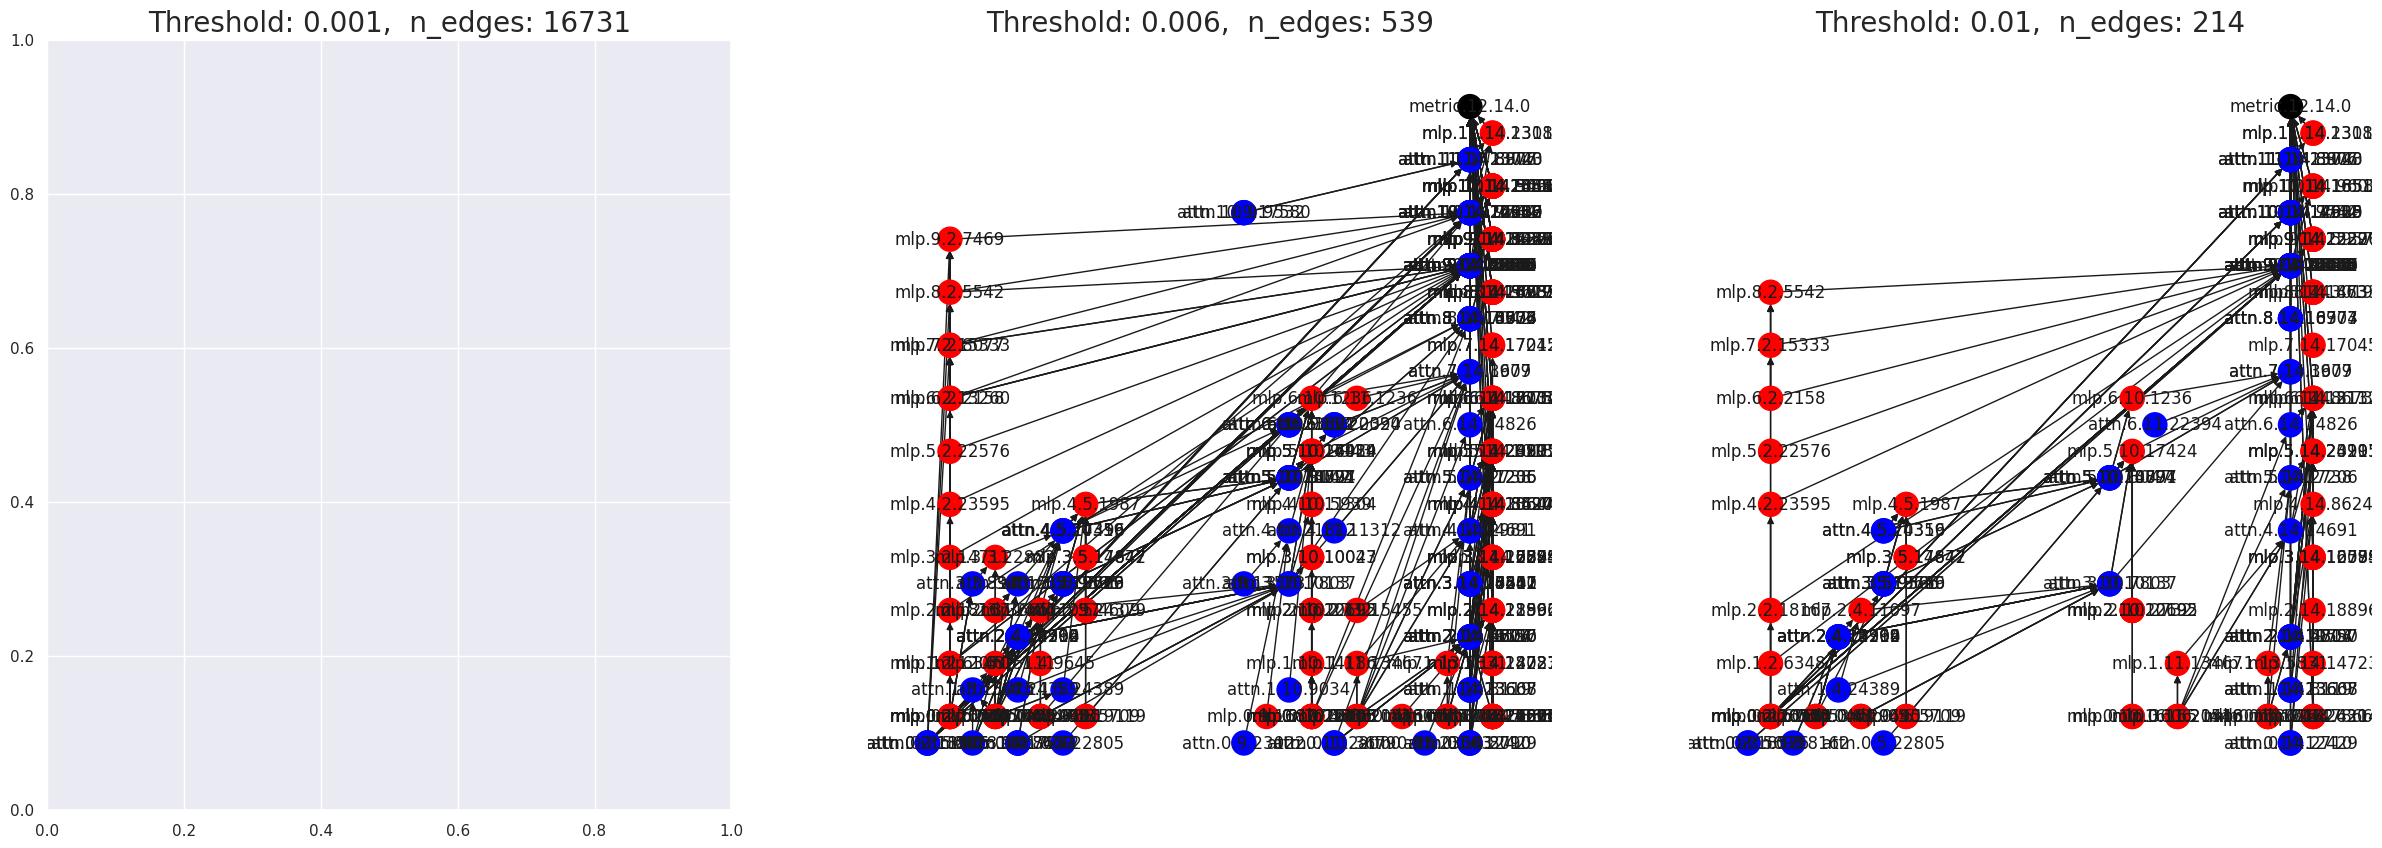

In [37]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
thresholds = [
    0.001,
    # 0.003,
    0.006,
    0.01,
]

for ax, threshold in zip(axs, thresholds):
    with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
        graph = EAPGraph.from_json(json.load(f))

    n_edges = len(graph.get_edges())
    print(f"Threshold: {threshold}, n_edges: {n_edges}")
    ax.set_title(f"Threshold: {threshold},  n_edges: {n_edges}", fontsize=20)

    if n_edges > 1000:
        continue
    show_attrib_graph(graph, ax=ax)


fig.show()

## Inspect the graph

In [26]:
threshold = 0.01
with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
    graph = EAPGraph.from_json(json.load(f))


In [27]:
## Print the distribution of nodes
import pandas as pd
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info, _ in graph.graph:
    dest, src = edge
    if 'metric' in src: continue
    nn_grad, nn_attrib, em_grad, em_attrib = edge_info 
    src_module_type, src_layer, src_token, src_feature = parse_node_name(src)
    dest_module_type, dest_layer, dest_token, dest_feature = parse_node_name(dest)
    rows.append({
        "src_module_type": src_module_type,
        "dest_module_type": dest_module_type,
        "src_layer": src_layer,
        "dest_layer": dest_layer,
        "src_token": src_token,
        "dest_token": dest_token,
        "src_feature": src_feature,
        "dest_feature": dest_feature,
        "nn_grad": nn_grad,
        "nn_attrib": nn_attrib,
        "em_grad": em_grad,
        "em_attrib": em_attrib,
    })
df = pd.DataFrame(rows)
print(len(df))
df.head()

199


,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
0,mlp,metric,0,12,14,14,630,0,0.002810,0.019612,0.002810,0.019612
1,mlp,metric,0,12,14,14,7866,0,0.002408,0.010465,0.002408,0.010465
2,mlp,metric,3,12,14,14,12785,0,0.005436,0.013014,0.005436,0.013014
3,mlp,metric,5,12,14,14,20197,0,0.008160,0.022608,0.008160,0.022608
4,mlp,metric,5,12,14,14,24211,0,0.008896,0.021895,0.008896,0.021895


Index(['src_layer', 'src_module_type', 'dest_module_type', 'dest_layer',
       'src_token', 'dest_token', 'src_feature', 'dest_feature', 'nn_grad',
       'nn_attrib', 'em_grad', 'em_attrib'],
      dtype='object')


Text(0.5, 1.0, 'Total edge attribution by src layer')

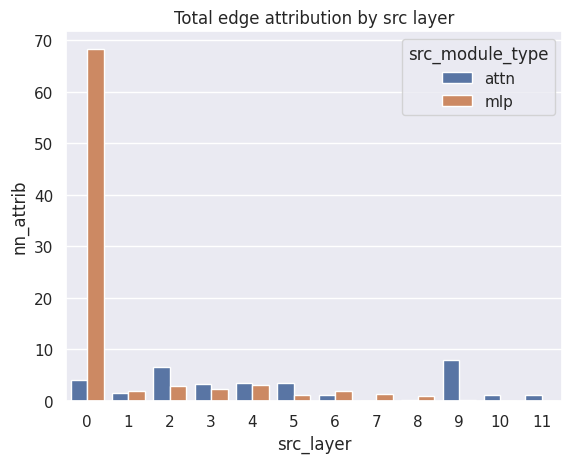

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

total_attrib_df = df.groupby(["src_layer", "src_module_type"]).sum().reset_index()
print(total_attrib_df.columns)
# Plot the total edge attribution by src layer
sns.barplot(x="src_layer", y="nn_attrib", data=total_attrib_df, hue="src_module_type")
plt.title("Total edge attribution by src layer")

Text(0.5, 1.0, 'Number of nodes in each layer')

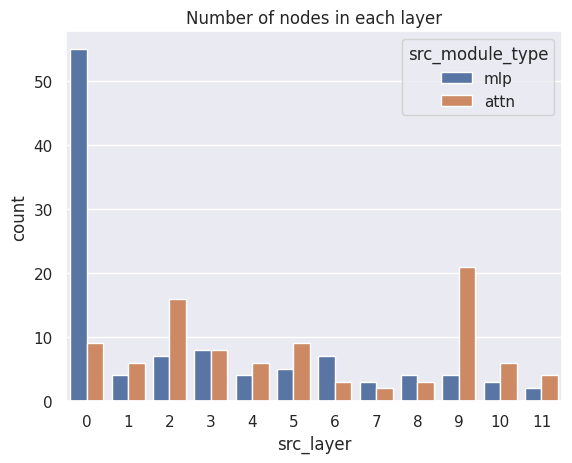

In [29]:
# Plot the number of nodes in each layer
sns.countplot(x="src_layer", data=df, hue="src_module_type")
plt.title("Number of nodes in each layer")

In [30]:
## Highest nodes by NN attrib

df.sort_values(by='em_attrib', ascending=False).head(10)

,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
35,attn,metric,9,12,14,14,4156,0,0.039003,0.668912,0.039003,0.668912
41,attn,metric,9,12,14,14,16109,0,0.029657,0.514048,0.029657,0.514048
33,attn,metric,9,12,14,14,2581,0,0.033615,0.437652,0.033615,0.437652
49,attn,metric,10,12,14,14,9532,0,0.030024,0.226353,0.030024,0.226353
37,attn,metric,9,12,14,14,5252,0,0.042130,0.164062,0.042130,0.164062
53,attn,metric,10,12,14,14,17580,0,0.039912,0.159988,0.039912,0.159988
176,mlp,attn,2,3,4,10,11097,7803,0.554409,1.377927,0.046208,0.114845
50,attn,metric,10,12,14,14,12629,0,0.026433,0.109547,0.026433,0.109547
52,attn,metric,10,12,14,14,14916,0,0.022631,0.106334,0.022631,0.106334
74,mlp,attn,0,9,2,14,10173,16109,0.814628,4.940011,0.017457,0.105860


### Layer 9 Attention SAE Features

In [31]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

layer = 9

features = df[
    (df.src_layer == layer) & 
    (df.src_module_type == 'attn')
]['src_feature'].unique()

print(get_neuronpedia_url_for_quick_list(layer, features, "att-kk"))

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%22249%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%221331%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%222581%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%222694%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%224156%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%224243%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%225252%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%226827%22%7D%2C

In [32]:
layer = 10

features = df[(df.src_layer == layer) & (df.src_module_type == "attn")][
    "src_feature"
].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%229532%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2212629%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2214903%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2214916%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2217580%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%227744%22%7D%5D'

In [35]:
layer = 0

features = df[(df.src_layer == layer) & (df.src_module_type == "mlp")][
    "src_feature"
].unique()

print(get_neuronpedia_url_for_quick_list(layer, features, "tres-dc"))

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%22630%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%227866%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%226287%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2216544%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2210173%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2220300%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2220261%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%222

# Plot Faithfulness Curve

<Axes: xlabel='num_nodes', ylabel='faithfulness'>

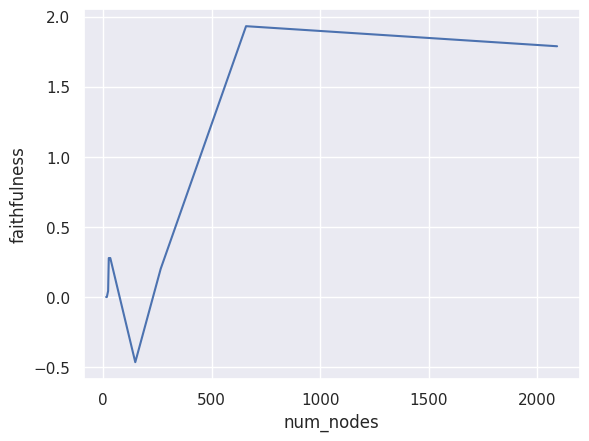

In [34]:
import seaborn as sns
sns.set_theme()

faithfulness_df = pd.read_csv(results_dir / "leap_experiment_results.csv")
sns.lineplot(data=faithfulness_df, x="num_nodes", y="faithfulness")